In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qmmc import *

## Generate data from a model

In [3]:
# Hyperpriors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
m, n = 5000, 3

# Priors and variables
mu_V_real = Normal(mu_0, sigma_0, value=0, name='mu_V_real')
sigma_V_real = InvGamma(scale_0, shape_0, value=3, name='sigma_V_real')
V_real = Normal(mu_V_real, sigma_V_real, size=m, name='V_real')

mu_Y_real = Normal(mu_0, sigma_0, value=-1, name='mu_WY_real')
sigma_Y_real = InvGamma(scale_0, shape_0, value=3, name='sigma_WY_real')
Y_real = Normal(mu_Y_real, sigma_Y_real, size=m, name='Y_real')

mu_W_real = Normal(mu_0, sigma_0, value=-0.5, name='mu_WY_real')
sigma_W_real = InvGamma(scale_0, shape_0, value=3, name='sigma_WY_real')
W_real = Normal(mu_W_real, sigma_W_real, size=(m, n), name='W_real')


@Function
def S_real(Y=Y_real, V=V_real, W=W_real):
    d = np.empty(Y.shape, dtype=int)
    
    C = np.min(W, axis=1)
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.0)
I_real = BernoulliFlip(p, S_real, k=3, name='flip')

In [4]:
print mu_V_real.value, sigma_V_real.value
print mu_W_real.value, sigma_W_real.value
f = 30
print S_real.value[:f]
print I_real.value[:f]

0 3
-0.5 3
[1 1 1 2 1 1 1 1 1 1 2 0 2 2 1 1 0 1 1 1 1 1 1 1 2 0 1 1 1 1]
[1 1 1 2 1 1 1 1 1 1 2 0 2 2 1 1 0 1 1 1 1 1 1 1 2 0 1 1 1 1]


In [5]:
W_real.value.min()

-11.901197429828651

## Estimate model parameters from data

In [6]:
# Priors and variables
mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=5, name='sigma_V')
V = Normal(mu_V, sigma_V, size=m, name='V')

Y = Value(Y_real.value)

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=5, name='sigma_W')
W = Normal(mu_W, sigma_W, size=(m, n), name='W')

@Function
def S(Y=Y, V=V, W=W):
    d = np.empty(Y.shape, dtype=int)
    
    C = np.min(W, axis=1)
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.0)
I = BernoulliFlip(p, S, k=3, value=I_real.value, observed=True, name='I')

In [7]:
v_sampler = VSampler(V)
w_sampler = WSampler(W)
pv_sampler = NormalConjugateSampler(mu_V, sigma_V)
pw_sampler = NormalConjugateSampler(mu_W, sigma_W)

In [8]:
model = Model(variables=[mu_V, sigma_V, V, mu_W, sigma_W, W, Y, S, I],
              samplers=[v_sampler, w_sampler, pv_sampler, pw_sampler])

In [9]:
model.samplers

{'V': <qmmc.custom_samplers.VSampler at 0x1033be7d0>,
 'W': <qmmc.custom_samplers.WSampler at 0x1099d6950>,
 'sigma_V & mu_V': <qmmc.custom_samplers.NormalConjugateSampler at 0x1099d6990>,
 'sigma_W & mu_W': <qmmc.custom_samplers.NormalConjugateSampler at 0x1099d69d0>}

In [10]:
print sum(I.value != S.value)
print sum(I_real.value != S_real.value)
print sum(I_real.value != I.value)

2350
0
0


In [32]:
# %%time
model.estimate(200)

0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 100%


In [33]:
W.value.min()

-35.910917579226393

In [34]:
print sum(I.value != S.value)
print sum(I_real.value != S_real.value)
print sum(I_real.value != I.value)

0
0
0


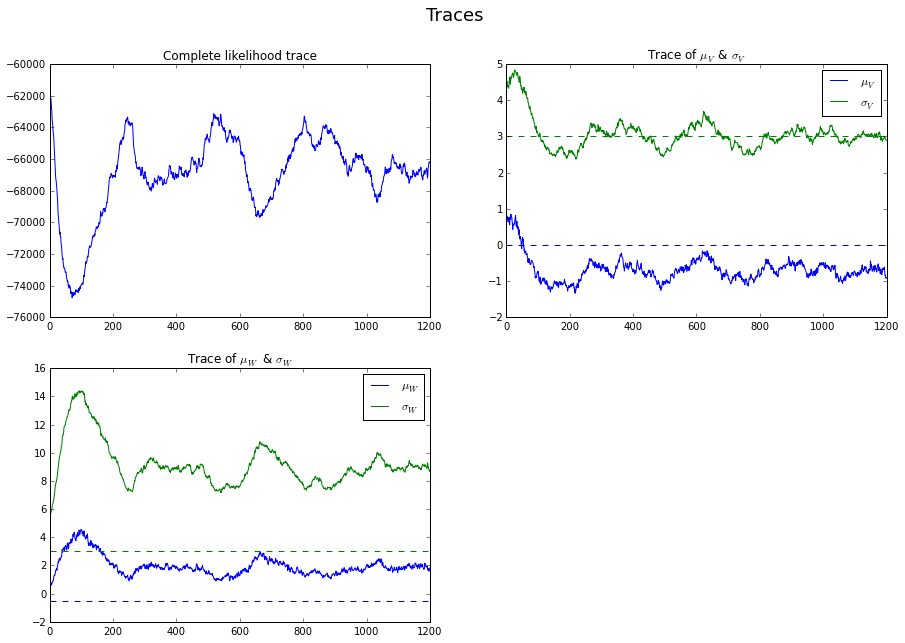

In [35]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(pv_sampler.history['mu'])
plt.plot(pv_sampler.history['sigma'])

plt.axhline(mu_V_real.value, linestyle='--')
plt.axhline(sigma_V_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
plt.plot(pw_sampler.history['mu'])
plt.plot(pw_sampler.history['sigma'])

plt.axhline(mu_W_real.value, linestyle='--')
plt.axhline(sigma_W_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.suptitle(r"Traces", size=18)
plt.show()

In [36]:
sum(I_real.value == 2)

1250

In [16]:
sum(I_real.value == 1)

3216

In [19]:
idx = I_real.value == 1
I = I_real.value[idx]
W = W_real.value[idx]
V = V_real.value[idx]
Y = Y_real.value[idx]
mu_W = mu_WY_real.value
sigma_W = sigma_WY_real.value


In [22]:
w = W
for _ in range(100):
    w = _sample_w(I, V, w, Y, mu_W, sigma_W)

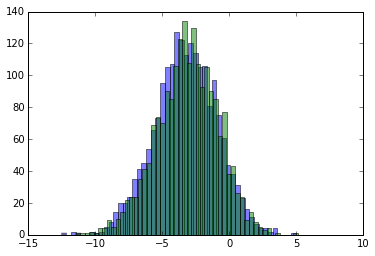

In [28]:
plt.hist(w, bins=50, alpha=.5)
plt.hist(W, bins=50, alpha=.5)
plt.show()

In [16]:
np.mean(W), np.mean(w)

(-3.1620192677158592, -3.1755483137236453)

In [20]:
idx  = I_real.value != S.value
print I_real.value[idx]
print S_real.value[idx]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1